In [1]:
from IPython.display import Image

# 生成对抗网络
　　GAN 的背后思想是你有两个网络，一个生成器  $G$ 和一个判别器 $D$，互相竞争。生成器会制造假数据传给判别器，判别器学习真实数据，并判断接受到的数据是真是假。生成器经过训练以欺骗判别器，输出尽可能接近真实数据的数据，即使得生成器生成的数据判别器都认为是真的。接着判别器进行训练，以确定哪些数据是真实的，哪些是假的。一直循环重复，最后，生成器将学会生成判别数据都无法区分真假的数据，即与真实数据差不多的假数据。

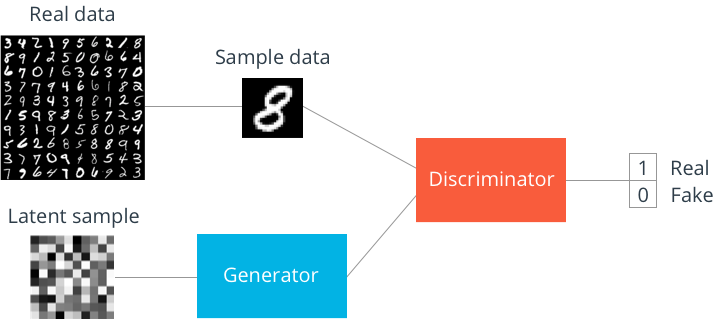

In [2]:
Image('https://github.com/udacity/deep-learning/raw/\
35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/gan_mnist/assets/gan_diagram.png')

　　GAN 的生成器结构如上图，使用 MNIST 的图片数据。潜在样本是生成器使用随机向量构造的假图片。当生成器通过训练来学习时，将生成器的随机变量（假图片）通过网络转换为能欺骗判别器的图像。判别器使用的是 sigmoid 函数，0表示假图像，1表示真图像。如果只对生成的新图像感兴趣，可以在训练好模型后丢弃判别器。

In [3]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Martin_Program\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## 模型和输入
　　首先我们要为 graph 创建输入层，有两个输入层，分别为生成器和判别器的。这里把判别器的输入层叫做 `inputs_real` ，生成器的输入层叫做 `inputs_z`，为每个网络分配适当的大小。

In [7]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## 生成器网络

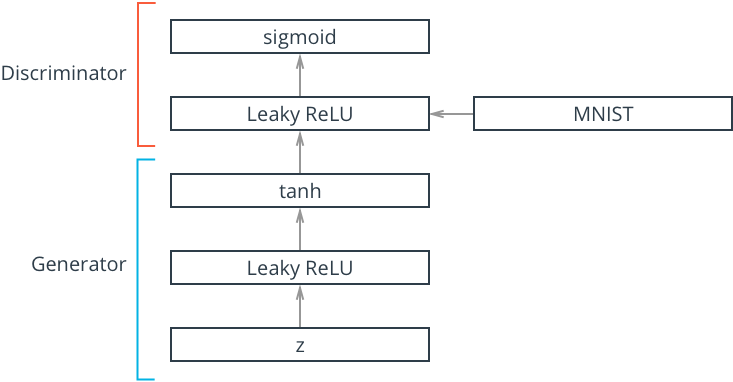

In [8]:
Image('https://github.com/udacity/deep-learning/raw/35ad0789cfb4a5d91e9adf8000f0b42be6d37c3b/gan_mnist/assets/gan_network.png')

　　建立生成器网络，使用 leaky ReLU，它属于 ReLU 的一个变种，当输入值为负数时，它会返回一个非常小的非零输出。
  
#### Variable Scope
　　这里需要使用 `tf.variable_scope` 有两个原因。第一，我们需要确保生成器的所有变量名以 `generator` 开头。类似的，判别器的以 `discriminator` 开头。这将有助于我们训练单个网络。<br />
　　我们可以使用 `tf.name_scope` 来设置名称，但也希望重用这些具有不同输入的网络。对于生成器，我们对其进行训练，但在训练中和训练后也会对其取样。判别器需要在假图像和真实输入图像之间共享变量。所以，当我们重建 graph 时，为 `tf.variable_scope` 设置`reuse` 来告诉 TensorFlow 重新使用这些变量，而不是创造新的变量。
```python
with tf.variable_scope('scope_name', reuse=False):
```
　　更多关于 `tf.variable_scope` 的内容 [the TensorFlow documentation](https://www.tensorflow.org/programmers_guide/variable_scope#the_problem) 

#### Leaky ReLU
　　TensorFlow 不提供  leaky ReLU 的操作，所以得自己写个自定义函数。为此，可以使用线性的全连接层输出并传递给 `tf.maximum`。通常，一个参数 `alpha` 设置负值的输出幅度。因此，负输入的值输出的是 `alpha*x`，而正输出的值输出的是 `x`:
$$
f(x) = max(\alpha * x, x)
$$

#### Tanh Output
　　实践表明生成器的输出使用 $tanh$ 的表现比较好，这意味着我们将 MNIST 的图像缩放到 -1 到 1 之间，取代 0 到 1 之间

In [9]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        # 隐藏层
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        # out_dim，输出维度对应判别器的输入维度
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

## 判别器
　　判别器的网络与生成器网络大致相同，除了判别器网络使用 sigmoid 的输出层。

In [10]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # 隐藏层
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

## 超参数

In [11]:
# 判别器的输入维度
input_size = 784
# 生成器生成的随机变量大小
z_size = 100
# 生成器和判别器的隐藏层大小
g_hidden_size = 128
d_hidden_size = 128
# leaky ReLU 参数
alpha = 0.01
# Smoothing 
smooth = 0.1

## 建立网络
　　首先使用 `model_inputs` 函数获得生成器和判别器的占位符。接着，使用 `generator(input_z, input_size)` 创建生成器。到判别器，我们建立两个，一个用于真实数据，一个用于假数据。因为我们需要保证两个判别器的权重一样，所以需要重用这些变量。真数据的判别器为 `discriminator(input_real)` ，而假数据的判别器为 `discriminator(g_model, reuse=True)`。

In [12]:
tf.reset_default_graph()
# 创建输入的占位符
input_real, input_z = model_inputs(input_size, z_size)
# 建立模型，判别器
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

# g_model 是生成器的输出，input_real 是真实数据
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

## 判别器和生成器的损失
　　现在我们需要计算损失，这里有些小技巧。对于判别器，总的损失是真实数据和假数据的损失之和，即 `d_loss = d_loss_real + d_loss_fake`。通过  `tf.nn.sigmoid_cross_entropy_with_logits` 获得损失，并使用 `tf.reduce_mean` 来计算一个batch的损失均值。

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

　　对于真实数据的 logits，使用前面  `discriminator` 函数获得的  `d_logits_real`。对于标签，都为1（对应的假数据为0），因为是真实数据。为了帮助判别器更好的泛化，真实数据的标签值从 1.0 减到 0.9。比如，使用参数 `smooth`，称为标签平滑，通过与分类器一起使用能提升效果。在 TensorFlow，代码如下： `labels = tf.ones_like(tensor) * (1 - smooth)`

　　假数据的判别器损失是类似，其 logits 为  `d_logits_fake`，将生成器的输出传到判别器。这个假的 logits 对应的为全零标签。记住判别器输出1表示真实数据，0为假数据，所以我们需要设置损失来反映这一点。<br />
　　最后，生成器的损失使用 `d_logits_fake`，假数据的 logits。但是，标签全为1。让生成器尝试骗过判别器，所以对于假数据判别器也会输出1。

In [13]:
# 计算损失
# 真实数据的损失，即输入为真实数据，需要判别器预测为1
d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                               labels=tf.ones_like(d_logits_real) * (1 - smooth)))
# 假数据的损失，即输入为假数据，需要判别器预测为0
d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                               labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

# 生成器的损失，即判别器的预测假数据的值，与标签为1的损失
g_loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                               labels=tf.ones_like(d_logits_fake)))

## 优化方法
　　我们想要分开更新生成器和判别器的变量，需要分开构建优化方法。使用 `tf.trainable_variables()` 获得所有可训练的变量，这将创建我们在 graph 定义的所有变量的列表。<br />
　　对于生成器的优化，只需要生成随机变量。从 `tf.trainable_variables()`  遍历列表，并保持变量以 `generator` 开头。每个变量对象都有一个属性 `name` ，它将变量的名称保存为字符串，如 `var.name == 'weights_0'`。同理对判别器做类似事情，判别器的所有变量以 `discriminator` 开头。然后，在优化器中，我们传递变量列表给 `minimize` 方法中的 `var_list`。告诉优化器只需更新这些列表中的变量，比如 `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` 只会训练更新 `var_list` 中的变量。

In [14]:
# 优化器
learning_rate = 0.002

# 获得 trainable_variables，切分为生成器和判别器的部分
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## 训练模型

In [15]:
# batch 大小
batch_size = 100
# 迭代次数
epochs = 100
samples = []
losses = []
# 只保存生成器的变量，只需要生成器的输出图片
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(mnist.train.num_examples // batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # 获得图片，重塑维度，并且对其缩放，然后传入判别器
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1

            # 为生成器生成随机样本
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # 运行优化器
            # 判别器
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                                      input_z: batch_z})
            # 生成器
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
            
        # 在每次迭代后，获取损失并打印出来
        # 判别器的损失，真实数据和假数据
        train_loss_d = sess.run(d_loss, {input_z: batch_z,
                                                          input_real: batch_images})
        # 生成器的损失
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print('Epoch {} / {}'.format(e+1, epochs),
                 'Discriminator Loss: {:.4f}'.format(train_loss_d),
                 'Generator Loss: {:.4f}'.format(train_loss_g ))
        # 训练完后保存损失
        losses.append((train_loss_d, train_loss_g))
        
        # 每训练迭代一轮后，使用随机样本传入生成器，保存生成器的输出结果
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       # 生成器的输出
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# 保存训练好后的生成器输出的样本
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1 / 100 Discriminator Loss: 0.3746 Generator Loss: 3.9028
Epoch 2 / 100 Discriminator Loss: 0.5089 Generator Loss: 2.5023
Epoch 3 / 100 Discriminator Loss: 0.4204 Generator Loss: 2.9895
Epoch 4 / 100 Discriminator Loss: 0.3860 Generator Loss: 3.9872
Epoch 5 / 100 Discriminator Loss: 0.4588 Generator Loss: 5.2914
Epoch 6 / 100 Discriminator Loss: 1.0498 Generator Loss: 5.6102
Epoch 7 / 100 Discriminator Loss: 1.3530 Generator Loss: 2.5942
Epoch 8 / 100 Discriminator Loss: 1.1350 Generator Loss: 2.2317
Epoch 9 / 100 Discriminator Loss: 0.5912 Generator Loss: 3.5332
Epoch 10 / 100 Discriminator Loss: 0.9670 Generator Loss: 1.6982
Epoch 11 / 100 Discriminator Loss: 1.1201 Generator Loss: 2.6182
Epoch 12 / 100 Discriminator Loss: 0.8501 Generator Loss: 2.6048
Epoch 13 / 100 Discriminator Loss: 1.0093 Generator Loss: 2.2054
Epoch 14 / 100 Discriminator Loss: 1.0756 Generator Loss: 2.8814
Epoch 15 / 100 Discriminator Loss: 1.2381 Generator Loss: 1.7131
Epoch 16 / 100 Discriminator Loss:

## 训练损失
　　检查生成器和判别器的损失。

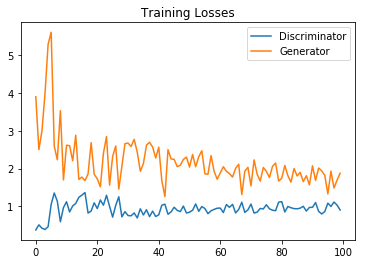

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title('Training Losses')
plt.legend()

## 生成器的样本
　　这里我们取一些生成器正在训练的样本。

In [18]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [17]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

　　这里有些样本来自最后一轮迭代的，可以看到生成器已经能生成像 1, 7, 3, 2 的数字。

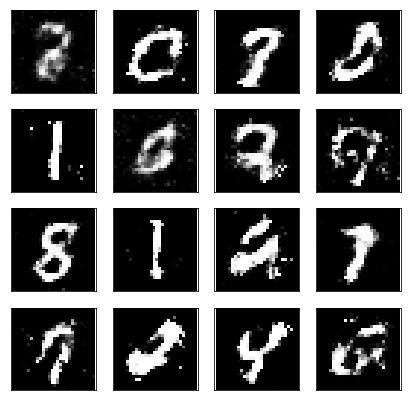

In [19]:
_ = view_samples(-1, samples)

　　下面展示网络在训练时，每10次迭代的图像。

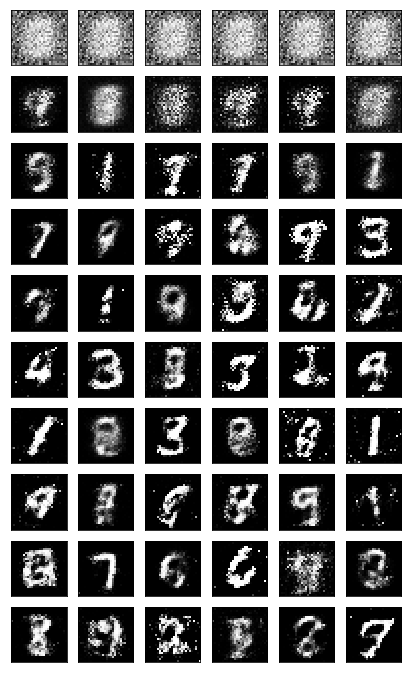

In [23]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

　　刚开始都是噪音，然后学会中间是白的，其余为黑的，接着能看到有些已有数字结构，比如1和9的。

## 从生成器中取样
　　在训练完后，我们也可以使用从生成器中生成新的图像，只需要传入新的随机向量 $z$，就能获得新的图像。

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


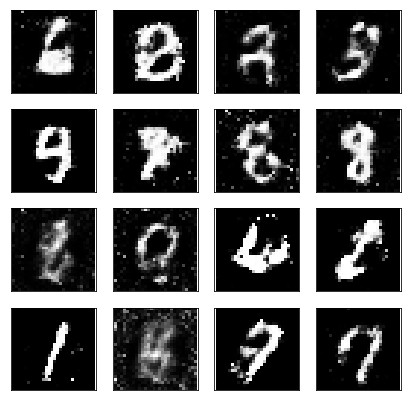

In [21]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                   generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                   feed_dict={input_z: sample_z})
_ = view_samples(0, [gen_samples])